In [1]:
import tensorflow as tf
import time
import tensorflow_hub as hub
import cv2
from PIL import Image
import uuid

from EfficientDet import *
import os
from glob import glob

# test_input에 대해서 object detection 수행

## pretrained model 가져오기

In [2]:
model = get_detector("https://tfhub.dev/tensorflow/efficientdet/d4/1")

In [3]:
dataset_path = "./original_test/"
output_path = "./detected_data/detected_from_test/"
dataset_list = os.listdir(dataset_path)

In [4]:
detected_objectList = object_detection(model, dataset_list,dataset_path, output_path)

Detection 수행시간: 7.27 초
Detection 수행시간: 7.27 초
Detection 수행시간: 0.18 초
Detection 수행시간: 0.18 초
Detection 수행시간: 0.18 초
Detection 수행시간: 0.19 초
Detection 수행시간: 0.19 초


# detected object를 선택


In [64]:
selectedObject = detected_objectList[0]

selectedObject_path = selectedObject["objectImagePath"]

In [65]:
selectedObject_pil = Image.open(selectedObject_path)


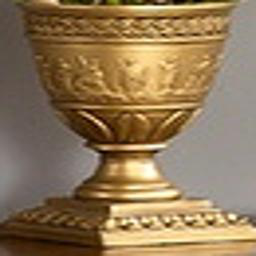

In [66]:
selectedObject_pil

1. readTest 다시 짜기 > selectedObject 하나만 읽어야함
2. read_imgs_test를 다시짜야함
3. apply_transformer도 selectedObject 하나만 변환하도록

In [67]:
from ImageRetrievalClass import ImageRetrievalClass
retrieval = ImageRetrievalClass("IncepResNet", True, False)
retrieval.readTestSet(selectedObject_pil)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


Reading train images
test image shape = (256, 256, 3)


In [68]:
retrieval.buildModel()

Loading IncepResNet pre-trained model...
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_609 (Conv2D)             (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_609 (BatchN (None, 127, 127, 32) 96          conv2d_609[0][0]                 
__________________________________________________________________________________________________
activation_609 (Activation)     (None, 127, 127, 32) 0           batch_normalization_609[0][0]    
_______________________________________

In [69]:
X_test = retrieval.testTransform()


Applying image transformer to test images...
 -> X_test.shape = (1, 256, 256, 3)


In [70]:
E_test = retrieval.predictTest(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(retrieval.output_shape_model)))

Inferencing embeddings using pre-trained model...
 -> E_test.shape = (1, 6, 6, 1536)


# 동일 태그를 가진 객체들을 검색대상 pool에서 가져오기
- 추후 mongoDB 쿼리부분으로 바뀌어야 함

In [71]:
selectedObject

{'objectID': 'a2626f58-4292-49f2-ba59-e482abb0d6f1',
 'location': {'xmin': 102, 'ymin': 321, 'xmax': 194, 'ymax': 386},
 'tag': 'vase',
 'objectImagePath': './detected_data/detected_from_test/vase1_path_(.-original_test-100356.png).jpg',
 'IMG_URL': '100356.png'}

In [72]:
jsonFiles_path = glob("./jsonFiles/*.json")

In [73]:
import json
queryed_json_pathList = list()
queryed_jsonList = list()
for path in jsonFiles_path:
    with open(path, "rb") as f:
        jsonFile = json.load(f)
    
    if jsonFile["tag"] == selectedObject["tag"]:
        queryed_json_pathList.append(path)
        queryed_jsonList.append(jsonFile)

In [74]:
queryed_jsonList[0]

{'objectID': '98463601-5f14-418d-9c35-711bd1d90bf0',
 'location': {'xmin': 256, 'ymin': 393, 'xmax': 303, 'ymax': 414},
 'tag': 'vase',
 'objectImagePath': './detected_data/detected_from_train/vase463_path_(.-original_train-수납장-621119.png).jpg',
 'npyPath': './npyFiles/vase463_path_(.-original_train-수납장-621119.png).npy',
 'IMG_URL': '621119.png'}

# 태그로 쿼리한 json 파일의 npy(E_train)과 E_test를 비교

## json에서 npy가져와서 E_train 만들기

In [75]:
E_train = list()
for json in queryed_jsonList:
    npy = np.load(json["npyPath"])
    E_train.append(npy)


In [76]:
E_train = np.array(E_train)


In [77]:
E_train_flatten = E_train.reshape((-1, np.prod(retrieval.output_shape_model)))
E_test_flatten.shape

(1, 55296)

In [78]:
# E_train_flatten =np.load("E_train_flatten.npy")

In [79]:
E_train_flatten.shape

(524, 55296)

In [80]:
calculator = retrieval.similarityCalculator(E_train_flatten)

Fitting k-nearest-neighbour model on training images...


## 쿼리 결과의 pool 만들기

In [81]:
retrieval_imagePool = [Image.open(json["objectImagePath"]) for json in queryed_jsonList]



## Retrieval

In [82]:
retrieval.retrieval(E_test_flatten=E_test_flatten, calculator=calculator, retrieval_imagePool=retrieval_imagePool )

Performing image retrieval on test images...


E_test_flatten.shape

In [83]:
# 원본 이미지 